In [1]:
# !pip install conllu stanza scikit-learn nltk

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# IMPORT DAN PERSIAPAN

import nltk
from conllu import parse_incr
import random
import stanza
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer
import dill
import joblib

# Pembuatan dan Evaluasi POS Tagger untuk Bahasa Inggris

## Load Data dan Eksplorasi

🟦 **Dataset**:

- Dataset menggunakan [UD English EWT](https://github.com/UniversalDependencies/UD_English-EWT/tree/master).
- POS tags menggunakan Universal POS tags (UPOS).
- Split: gunakan train, dev, test resmi dari UD untuk konsistensi riset.


**Universal POS tags**

https://universaldependencies.org/u/pos/

Terdapat 17 POS tag pada Universal POS tags yang terbagi menjadi open class, closed class, dan lainnya.

| Open class words | Closed class words | Other   |
|------------------|--------------------|---------|
| ADJ              | ADP                | PUNCT   |
| ADV              | AUX                | SYM     |
| INTJ             | CCONJ              | X       |
| NOUN             | DET                |         |
| PROPN            | NUM                |         |
| VERB             | PART               |         |
|                  | PRON               |         |
|                  | SCONJ              |         |



In [4]:
# LOAD UD ENGLISH EWT

# Fungsi load conllu jadi tagged_sents
def load_ud_conllu(filepath):
    sentences = []
    with open(filepath, "r", encoding="utf-8") as f:
        for tokenlist in parse_incr(f):
            sent = [(token['form'], token['upos']) for token in tokenlist if token['form'] is not None]
            sentences.append(sent)
    return sentences

train_sents = load_ud_conllu("en_ewt-ud-train.conllu")
dev_sents = load_ud_conllu("en_ewt-ud-dev.conllu")
test_sents = load_ud_conllu("en_ewt-ud-test.conllu")

🟦 **Explorasi Dataset**

- Contoh kalimat dan tagging.
- Distribusi panjang kalimat.
- Distribusi tag.

In [5]:
# EKSPLORASI DATASET

# Satu contoh kalimat
print("Contoh kalimat:")
random.seed(19)
sample_sentence = random.choice(train_sents)
print("Kalimat:", " ".join([word for word, tag in sample_sentence]))
print("\nPOS tags:")
for word, tag in sample_sentence:
    print(f"- {word} : ({tag})")


Contoh kalimat:
Kalimat: I work as a Transformational Life Coach .

POS tags:
- I : (PRON)
- work : (VERB)
- as : (ADP)
- a : (DET)
- Transformational : (ADJ)
- Life : (NOUN)
- Coach : (NOUN)
- . : (PUNCT)


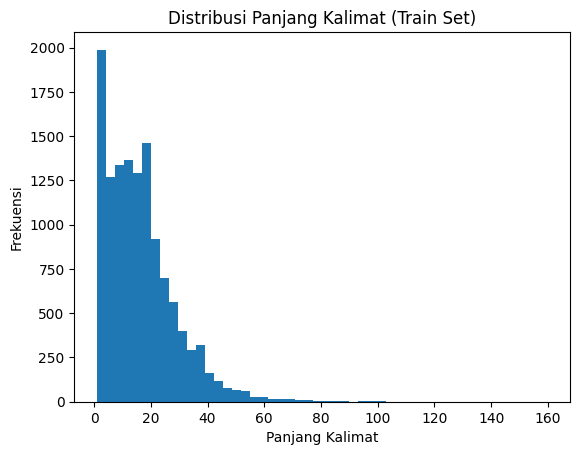

In [6]:
# Distribusi panjang kalimat
sent_lengths = [len(sent) for sent in train_sents]
plt.hist(sent_lengths, bins=50)
plt.title("Distribusi Panjang Kalimat (Train Set)")
plt.xlabel("Panjang Kalimat")
plt.ylabel("Frekuensi")
plt.show()


In [7]:
# Tag unik
tags = [tag for sent in train_sents for (_, tag) in sent]
print(f"Tag unik ({len(set(tags))}): {set(tags)}")

print("\nDistribusi tag (Top 10):")
top_tags = Counter(tags).most_common(10)
for tag, count in top_tags:
    print(f"- {tag}: {count} ({count / len(tags) * 100:.2f}%)")


Tag unik (18): {'ADV', 'NOUN', 'AUX', 'ADJ', '_', 'PRON', 'NUM', 'INTJ', 'PART', 'PUNCT', 'SCONJ', 'PROPN', 'X', 'DET', 'VERB', 'ADP', 'CCONJ', 'SYM'}

Distribusi tag (Top 10):
- NOUN: 34751 (16.77%)
- PUNCT: 23596 (11.39%)
- VERB: 22603 (10.91%)
- PRON: 18677 (9.01%)
- ADP: 17748 (8.56%)
- DET: 16299 (7.87%)
- ADJ: 13138 (6.34%)
- AUX: 12818 (6.19%)
- PROPN: 12620 (6.09%)
- ADV: 10167 (4.91%)


## Model Training

🟦 **Model Training**

- HMM POS Tagger (NLTK).
- Logistic Regression POS Tagger (scikit-learn)

### Hidden Markov Model

In [8]:
# TRAINING HMM POS TAGGER (NLTK)

from nltk.tag.hmm import HiddenMarkovModelTrainer
import time

# Format data untuk HMM
trainer = HiddenMarkovModelTrainer()

start_time = time.time()
hmm_tagger = trainer.train_supervised(train_sents)
end_time = time.time()

training_time_hmm = end_time - start_time
print(f"Waktu training HMM POS Tagger: {training_time_hmm:.2f} detik")

# Simpan model HMM menggunakan dill
with open("hmm_pos_tagger.pkl", "wb") as f:
    dill.dump(hmm_tagger, f)


Waktu training HMM POS Tagger: 0.28 detik


In [9]:
# Load HMM model
with open("hmm_pos_tagger.pkl", "rb") as f:
    hmm_tagger = dill.load(f)

# Lihat akurasi HMM pada dev set
y_true_dev = [tag for sent in dev_sents for (_, tag) in sent]
y_pred_dev = [tag for sent in dev_sents for (_, tag) in hmm_tagger.tag([word for word, _ in sent])]
hmm_accuracy_dev = accuracy_score(y_true_dev, y_pred_dev)
print(f"HMM Accuracy (dev): {hmm_accuracy_dev:.4f}\n")



HMM Accuracy (dev): 0.5737



### Logistic Regression

Logistic Regression tidak bisa menerima kata secara langsung, maka perlu:
- Mengubah kata menjadi representasi numerik (One-Hot Encoding dari feature dictionary)

🟦 **Feature Extraction**

- word.lower(): agar insensitive terhadap casing. (`The` vs `the`)
- word[-3:]: 3 huruf terakhir kata untuk menangkap suffix (`-ing`)
- words[-2:]: 2 huruf terakhir dari kata untuk menangkap suffix (`-ed`, `ly`)
- word.isupper(): menangkap seluruh huruf kapital, biasanya proper noun (`USA`, `NASA`)
- word.istitle(): menangkap huruf pertama kapital, biasanya proper noun (`John`, `Jakarta`)
- word.isdigit(): menangkap token dalam bentuk angka (`2025`, `123`)

In [10]:
# TRAINING LOGISTIC REGRESSION POS TAGGER (scikit-learn)

# Feature Extractor
def word2features(sent, i):
    word = sent[i][0]
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
        })
    else:
        features['EOS'] = True

    return features

def prepare_data(sents):
    X, y = [], []
    for sent in sents:
        for i in range(len(sent)):
            X.append(word2features(sent, i))
            y.append(sent[i][1])
    return X, y

X_train, y_train = prepare_data(train_sents)
X_dev, y_dev = prepare_data(dev_sents)

# Vectorizer
vec = DictVectorizer(sparse=True)


In [11]:
import time

# Model Training
X_train_vec = vec.fit_transform(X_train)
X_dev_vec = vec.transform(X_dev)

logreg = LogisticRegression(max_iter=200)
start_time = time.time()
logreg.fit(X_train_vec, y_train)
end_time = time.time()

training_time_logreg = end_time - start_time
print(f"Waktu training Logistic Regression POS Tagger: {training_time_logreg:.2f} detik")

# Simpan model Logistic Regression
joblib.dump(logreg, "logreg_pos_tagger.pkl")


Waktu training Logistic Regression POS Tagger: 36.53 detik


['logreg_pos_tagger.pkl']

In [12]:
# Load model Logistic Regression
logreg = joblib.load("logreg_pos_tagger.pkl")

# Lihat akurasi Logistic Regression pada dev set
y_pred_dev = logreg.predict(X_dev_vec)
logreg_accuracy_dev = accuracy_score(y_dev, y_pred_dev)
print(f"Logistic Regression Accuracy (dev): {logreg_accuracy_dev:.4f}")

Logistic Regression Accuracy (dev): 0.9324


## Evaluasi

🟦 Evaluasi:

- Accuracy keseluruhan.
- Classification Report: Precision, Recall, F1 tiap tag.
- Confusion Matrix.

🟦 Prediction Testing:

- Pilih 1 kalimat acak dari data testing.
- Predict POS tag dengan HMM dan Logistic Regression.

In [13]:
with open("hmm_pos_tagger.pkl", "rb") as f:
    hmm_tagger = dill.load(f)
    print("✅ HMM berhasil dimuat:", type(hmm_tagger))


logreg = joblib.load("logreg_pos_tagger.pkl")
print("✅ Logistic Regression berhasil dimuat:", type(logreg))

def evaluate_on_dataset(dataset_sents, dataset_name, model_type="hmm"):
    y_true = []
    y_pred = []

    for sent in dataset_sents:
        tokens = [word for word, tag in sent]
        true_tags = [tag for word, tag in sent]

        if model_type == "hmm":
            pred_tags = [tag for word, tag in hmm_tagger.tag(tokens)]
        elif model_type == "logreg":
            # Extract features for logistic regression
            test_feats = [word2features(sent, i) for i in range(len(tokens))]
            X_test_vec = vec.transform(test_feats)
            pred_tags = logreg.predict(X_test_vec)
        else:
            raise ValueError("model_type must be 'hmm' or 'logreg'")

        y_true.extend(true_tags)
        y_pred.extend(pred_tags)

    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_type.upper()} Accuracy {dataset_name}: {accuracy:.4f}")

    print(f"\n{model_type.upper()} Classification Report {dataset_name}:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    return y_true, y_pred, accuracy


✅ HMM berhasil dimuat: <class 'nltk.tag.hmm.HiddenMarkovModelTagger'>
✅ Logistic Regression berhasil dimuat: <class 'sklearn.linear_model._logistic.LogisticRegression'>


### Evaluasi Hidden Markov Model

HMM Accuracy (test): 0.5688

HMM Classification Report (test):

              precision    recall  f1-score   support

         ADJ       0.93      0.53      0.67      1788
         ADP       0.92      0.49      0.64      2029
         ADV       0.90      0.57      0.70      1191
         AUX       0.92      0.64      0.76      1543
       CCONJ       0.99      0.50      0.66       736
         DET       0.98      0.61      0.75      1897
        INTJ       0.95      0.74      0.83       121
        NOUN       0.95      0.44      0.60      4123
         NUM       0.94      0.28      0.43       542
        PART       0.95      0.61      0.74       649
        PRON       0.98      0.70      0.82      2165
       PROPN       0.16      0.97      0.28      2075
       PUNCT       1.00      0.45      0.62      3096
       SCONJ       0.81      0.48      0.60       384
         SYM       0.92      0.31      0.47       109
        VERB       0.94      0.58      0.72      2606
           X     

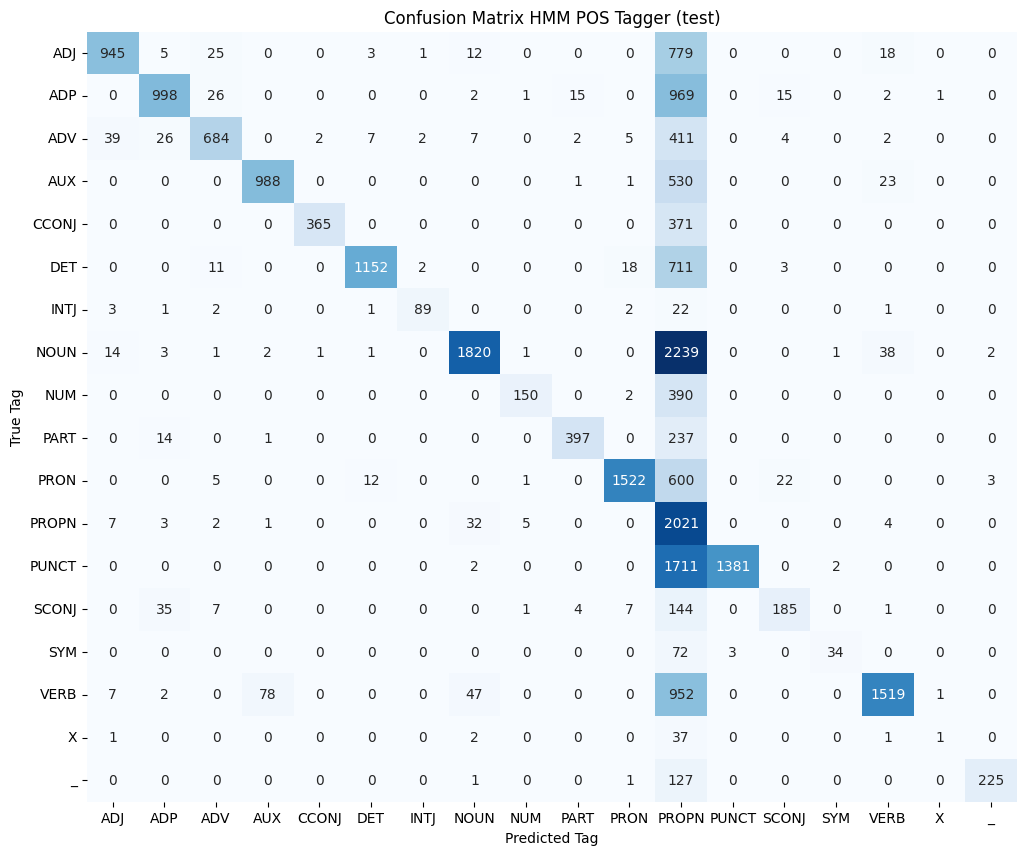

In [14]:
# EVALUASI HMM TAGGER PADA TEST SET
y_true_test, y_pred_test, hmm_accuracy_test = evaluate_on_dataset(test_sents, "(test)", model_type="hmm")

# Confusion Matrix pada TEST SET
cm = confusion_matrix(y_true_test, y_pred_test, labels=np.unique(y_true_test))

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    xticklabels=np.unique(y_true_test),
    yticklabels=np.unique(y_true_test),
    cmap="Blues",
    annot=True,
    fmt='d',
    cbar=False
)
plt.xlabel("Predicted Tag")
plt.ylabel("True Tag")
plt.title("Confusion Matrix HMM POS Tagger (test)")
plt.show()

### Evaluasi Logistic Regression

LOGREG Accuracy (test): 0.9334

LOGREG Classification Report (test):

              precision    recall  f1-score   support

         ADJ       0.92      0.87      0.89      1788
         ADP       0.93      0.96      0.94      2029
         ADV       0.91      0.90      0.91      1191
         AUX       0.97      0.98      0.98      1543
       CCONJ       0.99      0.99      0.99       736
         DET       0.98      0.98      0.98      1897
        INTJ       0.99      0.77      0.87       121
        NOUN       0.87      0.91      0.89      4123
         NUM       0.94      0.90      0.92       542
        PART       0.93      0.99      0.96       649
        PRON       0.98      0.98      0.98      2165
       PROPN       0.85      0.83      0.84      2075
       PUNCT       0.99      0.99      0.99      3096
       SCONJ       0.88      0.73      0.80       384
         SYM       0.82      0.84      0.83       109
        VERB       0.94      0.94      0.94      2606
           

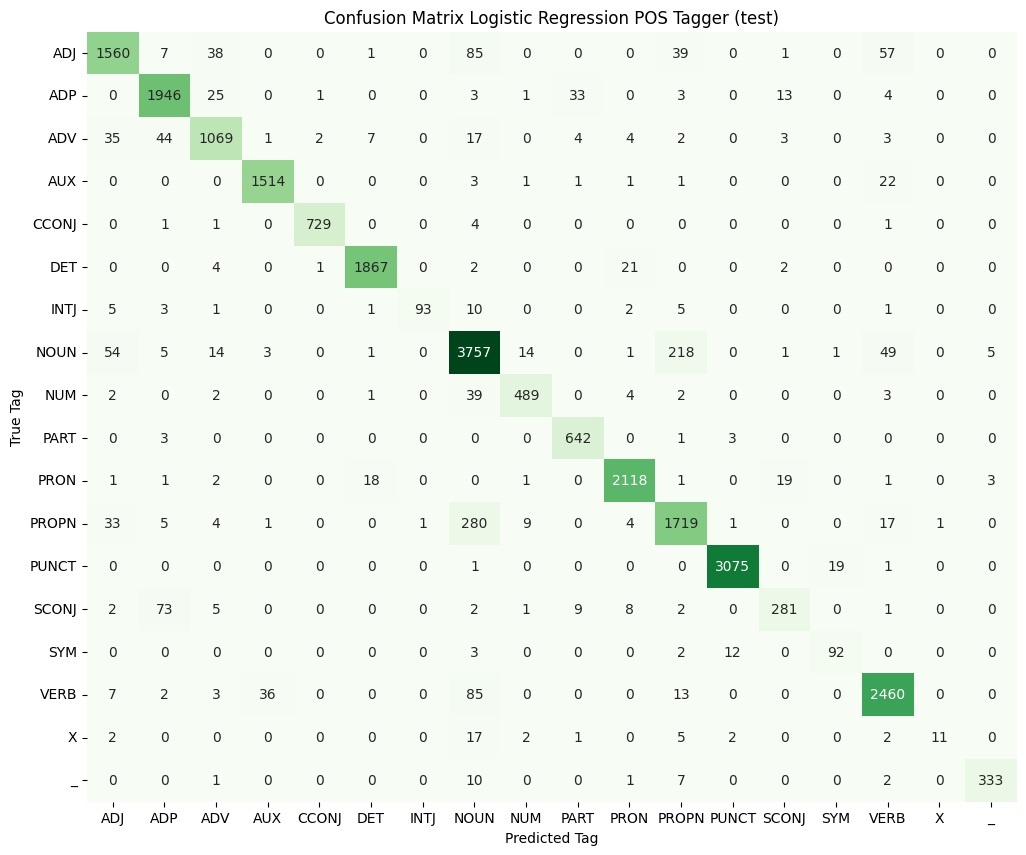

In [15]:
# EVALUASI LOGISTIC REGRESSION TAGGER PADA TEST SET
y_true_test_logreg, y_pred_test_logreg, logreg_accuracy_test = evaluate_on_dataset(test_sents, "(test)", model_type="logreg")

# Confusion Matrix pada TEST SET
cm_logreg = confusion_matrix(y_true_test_logreg, y_pred_test_logreg, labels=np.unique(y_true_test_logreg))

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_logreg,
    xticklabels=np.unique(y_true_test_logreg),
    yticklabels=np.unique(y_true_test_logreg),
    cmap="Greens",
    annot=True,
    fmt='d',
    cbar=False
)
plt.xlabel("Predicted Tag")
plt.ylabel("True Tag")
plt.title("Confusion Matrix Logistic Regression POS Tagger (test)")
plt.show()

In [16]:
# REKAP HASIL

import pandas as pd

results = {
    "Model": ["HMM POS Tagger", "Logistic Regression POS Tagger"],
    "Accuracy (dev)": [f"{hmm_accuracy_dev*100:.2f}%", f"{logreg_accuracy_dev*100:.2f}%"],
    "Accuracy (test)": [f"{hmm_accuracy_test*100:.2f}%", f"{logreg_accuracy_test*100:.2f}%"],
    "Training Time (s)": [round(training_time_hmm, 3), round(training_time_logreg, 3)],
}
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy (dev),Accuracy (test),Training Time (s)
0,HMM POS Tagger,57.37%,56.88%,0.282
1,Logistic Regression POS Tagger,93.24%,93.34%,36.531


## Analisis Kesalahan

🟦 Analisis Kesalahan

- Pilih satu kalimat acak dari test set.
- Prediksi dengan HMM, Logistic Regression, dan model pretrained (Stanza).
- Bandingkan dengan POS tag sebenarnya.

In [17]:
# Init Stanza
# stanza.download('en')

In [18]:
# ANALISIS KESALAHAN

# Pilih satu kalimat secara random dari test set
random.seed(3)
sample_test_sent = random.choice(test_sents)

# Prediksi dengan HMM
tokens_sample = [word for word, _ in sample_test_sent]
hmm_pred = hmm_tagger.tag(tokens_sample)
hmm_tags_only = [tag for word, tag in hmm_pred]

# Prediksi dengan Logistic Regression
sample_feats = [word2features(sample_test_sent, i) for i in range(len(tokens_sample))]
X_sample_vec = vec.transform(sample_feats)
logreg_pred = logreg.predict(X_sample_vec)

# Prediksi dengan Stanza (pretrained model)
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos', tokenize_pretokenized=True)
doc = nlp([tokens_sample])
stanza_tags = [word.upos for sent in doc.sentences for word in sent.words]

# True tags
true_tags = [tag for _, tag in sample_test_sent]


2025-07-03 20:20:05 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-07-03 20:20:06 INFO: Downloaded file to C:\Users\hafid\stanza_resources\resources.json
2025-07-03 20:20:06 INFO: Loading these models for language: en (English):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| pos       | combined_charlm |

2025-07-03 20:20:06 INFO: Using device: cpu
2025-07-03 20:20:06 INFO: Loading: tokenize
2025-07-03 20:20:06 INFO: Loading: pos
2025-07-03 20:20:10 INFO: Done loading processors!


In [19]:
# PERBANDINGAN HASIL POS TAGGING
print("\nKalimat yang dipilih:")
print(" ".join(tokens_sample))
print("\nPanjang kalimat:", len(tokens_sample), "kata")

print("\n" + "=" * 80)
print("PERBANDINGAN HASIL POS TAGGING")
print("=" * 80)

print(f"{'No':<3} {'Word':<12} {'True':<8} {'HMM':<8} {'LogReg':<8} {'Stanza':<8} {'HMM_OK':<7} {'LogReg_OK':<9} {'Stanza_OK'}")
print("-" * 80)

hmm_correct = 0
logreg_correct = 0
stanza_correct = 0

for i, word in enumerate(tokens_sample):
    true_tag = true_tags[i]
    hmm_tag = hmm_tags_only[i]
    logreg_tag = logreg_pred[i]
    stanza_tag = stanza_tags[i]
    
    hmm_match = "✓" if hmm_tag == true_tag else "✗"
    logreg_match = "✓" if logreg_tag == true_tag else "✗"
    stanza_match = "✓" if stanza_tag == true_tag else "✗"
    
    if hmm_tag == true_tag:
        hmm_correct += 1
    if logreg_tag == true_tag:
        logreg_correct += 1
    if stanza_tag == true_tag:
        stanza_correct += 1
    
    print(f"{i+1:<3} {word:<12} {true_tag:<8} {hmm_tag:<8} {logreg_tag:<8} {stanza_tag:<8} {hmm_match:<7} {logreg_match:<9} {stanza_match}")

print("-" * 80)
print("AKURASI pada kalimat ini:")
print(f"HMM: {hmm_correct}/{len(tokens_sample)} = {hmm_correct/len(tokens_sample)*100:.1f}%")
print(f"LogReg: {logreg_correct}/{len(tokens_sample)} = {logreg_correct/len(tokens_sample)*100:.1f}%")
print(f"Stanza: {stanza_correct}/{len(tokens_sample)} = {stanza_correct/len(tokens_sample)*100:.1f}%")




Kalimat yang dipilih:
Microsoft is 4 - 0 ( they took down Netscape , Suns Systems , MAC and IBM ) and Google may be their next target .

Panjang kalimat: 26 kata

PERBANDINGAN HASIL POS TAGGING
No  Word         True     HMM      LogReg   Stanza   HMM_OK  LogReg_OK Stanza_OK
--------------------------------------------------------------------------------
1   Microsoft    PROPN    PROPN    PROPN    PROPN    ✓       ✓         ✓
2   is           AUX      AUX      AUX      AUX      ✓       ✓         ✓
3   4            NUM      NUM      NUM      NUM      ✓       ✓         ✓
4   -            SYM      SYM      PUNCT    SYM      ✓       ✗         ✓
5   0            NUM      NUM      NUM      NUM      ✓       ✓         ✓
6   (            PUNCT    PUNCT    PUNCT    PUNCT    ✓       ✓         ✓
7   they         PRON     PRON     PRON     PRON     ✓       ✓         ✓
8   took         VERB     VERB     VERB     VERB     ✓       ✓         ✓
9   down         ADP      ADP      ADP      ADP      ✓     

In [20]:
print("\n" + "=" * 80)
print("ANALISIS KESALAHAN")
print("=" * 80)

print("\nKalimat yang dipilih:")
print(" ".join(tokens_sample))

errors_hmm = [(i, tokens_sample[i], true_tags[i], hmm_tags_only[i]) 
              for i in range(len(tokens_sample)) if hmm_tags_only[i] != true_tags[i]]
errors_logreg = [(i, tokens_sample[i], true_tags[i], logreg_pred[i]) 
                 for i in range(len(tokens_sample)) if logreg_pred[i] != true_tags[i]]
errors_stanza = [(i, tokens_sample[i], true_tags[i], stanza_tags[i]) 
                 for i in range(len(tokens_sample)) if stanza_tags[i] != true_tags[i]]

print(f"\nKesalahan HMM ({len(errors_hmm)} kesalahan):")
for pos, word, true_tag, pred_tag in errors_hmm:
    print(f"  - '{word}': seharusnya {true_tag}, diprediksi {pred_tag}")

print(f"\nKesalahan LogReg ({len(errors_logreg)} kesalahan):")
for pos, word, true_tag, pred_tag in errors_logreg:
    print(f"  - '{word}': seharusnya {true_tag}, diprediksi {pred_tag}")

print(f"\nKesalahan Stanza ({len(errors_stanza)} kesalahan):")
for pos, word, true_tag, pred_tag in errors_stanza:
    print(f"  - '{word}': seharusnya {true_tag}, diprediksi {pred_tag}")

if len(errors_hmm) == 0:
    print("✅ HMM: Sempurna! Semua tag benar.")
if len(errors_logreg) == 0:
    print("✅ LogReg: Sempurna! Semua tag benar.")
if len(errors_stanza) == 0:
    print("✅ Stanza: Sempurna! Semua tag benar.")


ANALISIS KESALAHAN

Kalimat yang dipilih:
Microsoft is 4 - 0 ( they took down Netscape , Suns Systems , MAC and IBM ) and Google may be their next target .

Kesalahan HMM (11 kesalahan):
  - ',': seharusnya PUNCT, diprediksi PROPN
  - ',': seharusnya PUNCT, diprediksi PROPN
  - 'and': seharusnya CCONJ, diprediksi PROPN
  - ')': seharusnya PUNCT, diprediksi PROPN
  - 'and': seharusnya CCONJ, diprediksi PROPN
  - 'may': seharusnya AUX, diprediksi PROPN
  - 'be': seharusnya AUX, diprediksi PROPN
  - 'their': seharusnya PRON, diprediksi PROPN
  - 'next': seharusnya ADJ, diprediksi PROPN
  - 'target': seharusnya NOUN, diprediksi PROPN
  - '.': seharusnya PUNCT, diprediksi PROPN

Kesalahan LogReg (2 kesalahan):
  - '-': seharusnya SYM, diprediksi PUNCT
  - 'MAC': seharusnya PROPN, diprediksi NOUN

Kesalahan Stanza (0 kesalahan):
✅ Stanza: Sempurna! Semua tag benar.


## Visualisasi

🟦 Visualisasi POS tagging

- Gunakan displaCy untuk menampilkan POS tag.
- Visualisasi hubungan dependensi antarkata

Label-label hubungan dependensi yang digunakan spaCy mengikuti standar dari proyek Universal Dependencies (UD).

https://universaldependencies.org/u/dep/

|                     | Nominals     | Clauses   | Modifier words | Function Words |
|---------------------|--------------|-----------|----------------|----------------|
| Core arguments      | nsubj        | csubj     |                |                |
|                     | obj          | ccomp     |                |                |
|                     | iobj         | xcomp     |                |                |
| Non-core dependents | obl          | advcl     | advmod         | aux            |
|                     | vocative     |           | discourse      | cop            |
|                     | expl         |           |                | mark           |
|                     | dislocated   |           |                |                |
| Nominal dependents  | nmod         | acl       | amod           | det            |
|                     | appos        |           |                | clf            |
|                     | nummod       |           |                | case           |
| **Coordination**    | **Headless** | **Loose** | **Special**    | **Other**      |
| conj                | fixed        | list      | compound       | punct          |
| cc                  | flat         | parataxis | orphan         | root           |
|                     |              |           | goeswith       | dep            |
|                     |              |           | reparandum     |                |

In [21]:
# !python -m spacy download en_core_web_sm

In [22]:
# VISUALISASI displaCy

import spacy
from spacy import displacy

random.seed(122)
sample_test_sent_2 = random.choice(test_sents)
tokens_sample_2 = [word for word, _ in sample_test_sent_2]
sample_text_2 = " ".join(tokens_sample_2)

nlp_spacy = spacy.load('en_core_web_sm')
doc = nlp_spacy(sample_text_2)

# Visualisasi dengan displaCy
displacy.render(doc, style="dep", jupyter=True, options={'compact': True})


## Integrasi dengan Pipeline NLP (NER)

🟦 NER dengan spaCy

- Gunakan kalimat yang sama untuk predict NER.

In [23]:
# NER DENGAN spaCy

import spacy
from spacy import displacy

# Load spaCy pipeline
nlp = spacy.load("en_core_web_sm")

# Gunakan kalimat contoh yang sudah ada
sentence = " ".join(tokens_sample)

# Process kalimat
doc = nlp(sentence)

print("Visualisasi NER:")
displacy.render(doc, style="ent", jupyter=True)

Visualisasi NER:


Model spaCy `en_core_web_sm` dapat digunakan untuk memprediksi Named Entity Recognition (NER) pada suatu kalimat dari data test.

Dari kalimat tersebut didapatkan informasi:
- Microsoft, Netscape, Suns System, MAC, IBM, dan Google dikenali sebagai `ORG`, menunjukkan bahwa token tersebut membahas organisasi/perusahaan.
- 4 dikenali sebagai `CARDINAL` yang menunjukkan skor
